In [1]:
import pyspark
from pyspark.sql.functions import abs as abs_col
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

spark = (
    SparkSession.builder
    .appName("Big Data Analytics")
    .master("yarn")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 22:41:04 INFO SparkEnv: Registering MapOutputTracker
23/11/16 22:41:04 INFO SparkEnv: Registering BlockManagerMaster
23/11/16 22:41:04 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/16 22:41:04 INFO SparkEnv: Registering OutputCommitCoordinator


In [ ]:
df = spark.read.csv('gs://fifa_players/merged_raw_data.csv', header = True, inferSchema = True)
# If the cluster can't handle big dataset truncate more
# df = df.sample(False, 0.1)

In [3]:
df.printSchema()
df_read = df

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: timestamp (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: double (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: double (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: timestamp (nullable = true)
 |-- club_contract_valid_until: double (nullable = true)
 |-- nationality_id: integer (nullable = 

In [4]:
columns_to_drop = ['sofifa_id', 'player_url', 'short_name', 'long_name', 'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'UID', 'Year'] # Identifiers and URLs
columns_to_drop = columns_to_drop + ['club_team_id', 'club_name', 'league_name', 'nationality_id', 'nationality_name', 'nation_team_id'] # Club and nation names
columns_to_drop = columns_to_drop + ['dob', 'club_joined', 'club_contract_valid_until', 'club_loaned_from'] # Personal Details
columns_to_drop = columns_to_drop + ['club_position', 'club_jersey_number', 'nation_position', 'nation_jersey_number', 'player_positions'] # Positional Details
columns_to_drop = columns_to_drop + ['real_face', 'player_tags', 'player_traits'] # Aesthetic Details
columns_to_drop = columns_to_drop + ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'] # Derived Positional Details
df_dropped_unused= df_read.drop(*columns_to_drop)

In [5]:
df_dropped_unused.show(1,  vertical = True)

23/11/16 22:41:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------
 overall                     | 80            
 potential                   | 80            
 value_eur                   | 8000000.0     
 wage_eur                    | 90000.0       
 age                         | 30            
 height_cm                   | 192           
 weight_kg                   | 82            
 league_level                | 1.0           
 preferred_foot              | Left          
 weak_foot                   | 2             
 skill_moves                 | 2             
 international_reputation    | 2             
 work_rate                   | High/Medium   
 body_type                   | Normal (185+) 
 release_clause_eur          | null          
 pace                        | 76.0          
 shooting                    | 64.0          
 passing                     | 66.0          
 dribbling                   | 55.0          
 defending                   | 82.0          
 physic                      | 81.

In [6]:
null_count = df_dropped_unused.select([count(when(col(c).isNull(), c)).alias(c) for c in df_dropped_unused.columns]).toPandas()

# After looking at the null count, we figured there are five traits that Goal keepers do not have so we will have to do data imputation for that. 
# For columns like release_clause_eur, mentality composure and goalkeeping_speed, they have too many null counts so we will simply drop them.
df_dropped_unused = df_dropped_unused.drop('release_clause_eur', 'mentality_composure', 'goalkeeping_speed')


In [7]:
df_dropped_na = df_dropped_unused.dropna(subset = ['value_eur', 'wage_eur', 'league_level'])

In [8]:
# find the mean value for imputation needs
# Imputation for goalkeeper based on mean value
imputation_col = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
df_clone = df_dropped_na
for col in imputation_col:
    mean_value = df_dropped_na.select(mean(col)).collect()[0][0]
    df_clone = df_clone.na.fill(mean_value, subset=[col])


In [9]:
df_clone.select('passing').summary().show()

+-------+-----------------+
|summary|          passing|
+-------+-----------------+
|  count|             1448|
|   mean| 57.1606583072103|
| stddev|9.796056674133466|
|    min|             28.0|
|    25%|             51.0|
|    50%|57.16065830721003|
|    75%|             63.0|
|    max|             87.0|
+-------+-----------------+



In [10]:
# Now we will cast string to integer for the following columns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

string_cols = ['preferred_foot','work_rate', 'body_type']
for col in string_cols:
    print(df_clone.select(col).distinct().show())

indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in string_cols]
encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_vec") for column in string_cols]

pipeline = Pipeline(stages=indexers + encoders)

df_transformed = pipeline.fit(df_clone).transform(df_clone)

+--------------+
|preferred_foot|
+--------------+
|          Left|
|         Right|
+--------------+

None
+-------------+
|    work_rate|
+-------------+
|Medium/Medium|
|  High/Medium|
|     Low/High|
|      Low/Low|
|    High/High|
|   Medium/Low|
|     High/Low|
|  Medium/High|
|   Low/Medium|
+-------------+

None
+----------------+
|       body_type|
+----------------+
|   Stocky (170-)|
|   Normal (185+)|
|     Lean (185+)|
|Normal (170-185)|
|     Lean (170-)|
|  Lean (170-185)|
|   Normal (170-)|
|   Stocky (185+)|
|Stocky (170-185)|
|          Unique|
+----------------+

None


In [11]:
df_transformed.select([c + "_index" for c in string_cols] + [c + "_vec" for c in string_cols]).show()

+--------------------+---------------+---------------+------------------+-------------+-------------+
|preferred_foot_index|work_rate_index|body_type_index|preferred_foot_vec|work_rate_vec|body_type_vec|
+--------------------+---------------+---------------+------------------+-------------+-------------+
|                 1.0|            1.0|            2.0|         (1,[],[])|(8,[1],[1.0])|(9,[2],[1.0])|
|                 0.0|            0.0|            3.0|     (1,[0],[1.0])|(8,[0],[1.0])|(9,[3],[1.0])|
|                 0.0|            1.0|            1.0|     (1,[0],[1.0])|(8,[1],[1.0])|(9,[1],[1.0])|
|                 1.0|            3.0|            1.0|         (1,[],[])|(8,[3],[1.0])|(9,[1],[1.0])|
|                 1.0|            0.0|            1.0|         (1,[],[])|(8,[0],[1.0])|(9,[1],[1.0])|
|                 0.0|            6.0|            0.0|     (1,[0],[1.0])|(8,[6],[1.0])|(9,[0],[1.0])|
|                 0.0|            0.0|            0.0|     (1,[0],[1.0])|(8,[0],[1

+-------+-----------------+------------------+
|summary|        value_eur|          wage_eur|
+-------+-----------------+------------------+
|  count|             1448|              1448|
|   mean|2291414.364640884|11371.961325966851|
| stddev|5971030.220880979| 23406.11953469245|
|    min|           3000.0|             500.0|
|    25%|         300000.0|            2000.0|
|    50%|         700000.0|            4000.0|
|    75%|        1600000.0|           10000.0|
|    max|           7.75E7|          230000.0|
+-------+-----------------+------------------+



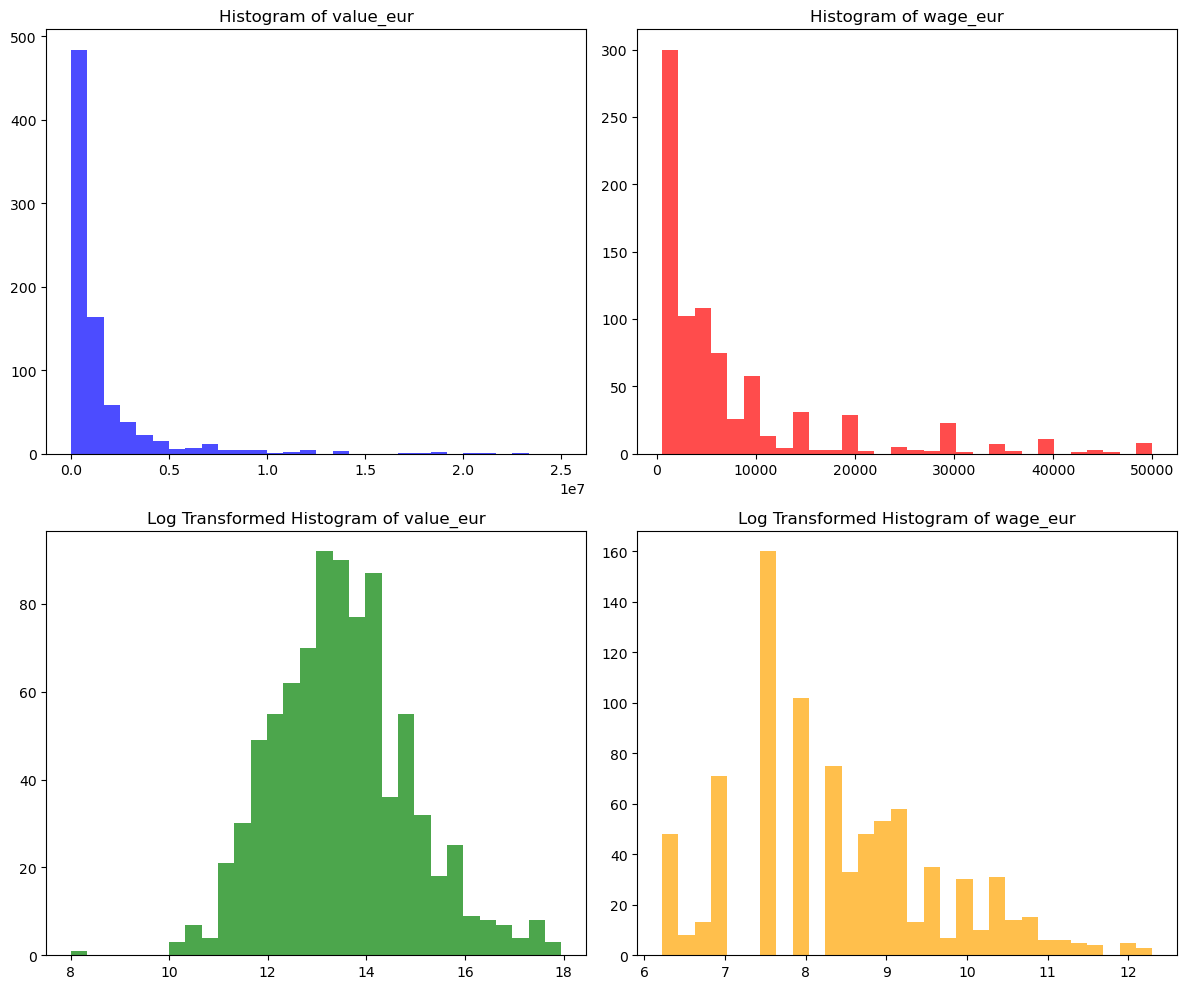

In [12]:
# before we vectorize the features, we will check if we need to do any scaling
df_transformed.select('value_eur', 'wage_eur').summary().show()
df = df_transformed
import matplotlib.pyplot as plt
import numpy as np

# Sampling a fraction of the data
sample_fraction = 0.6
sampled_data = df.select("value_eur", "wage_eur").sample(False, sample_fraction).toPandas()

# Adding logarithmic columns (log1p used to handle zero values)
sampled_data["log_value_eur"] = np.log1p(sampled_data["value_eur"])
sampled_data["log_wage_eur"] = np.log1p(sampled_data["wage_eur"])

# Plotting histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

min_max_values = df.select(
    min("value_eur").alias("min_value_eur"),
    max("value_eur").alias("max_value_eur"),
    min("wage_eur").alias("min_wage_eur"),
    max("wage_eur").alias("max_wage_eur")
).collect()[0]

min_value_eur, max_value_eur, min_wage_eur, max_wage_eur = min_max_values


# Original Value Histograms
axes[0].hist(sampled_data["value_eur"], bins=30, range = [min_value_eur, 25000000], color='blue', alpha=0.7)
axes[0].set_title('Histogram of value_eur')

axes[1].hist(sampled_data["wage_eur"], bins=30, range = [min_wage_eur, 50000], color='red', alpha=0.7)
axes[1].set_title('Histogram of wage_eur')

# Log Transformed Histograms
axes[2].hist(sampled_data["log_value_eur"], bins=30, color='green', alpha=0.7)
axes[2].set_title('Log Transformed Histogram of value_eur')

axes[3].hist(sampled_data["log_wage_eur"], bins=30, color='orange', alpha=0.7)
axes[3].set_title('Log Transformed Histogram of wage_eur')

plt.tight_layout()
plt.show()


In [13]:
# After viewing the histograms, we will do log transformation for value_eur and wage_eur
df_scaled = df_transformed.withColumn("log_value_eur", log1p("value_eur"))
df_scaled = df_scaled.withColumn("log_wage_eur", log1p("wage_eur"))

df_scaled.show(1, vertical = True)


-RECORD 0-----------------------------------------
 overall                     | 80                 
 potential                   | 80                 
 value_eur                   | 8000000.0          
 wage_eur                    | 90000.0            
 age                         | 30                 
 height_cm                   | 192                
 weight_kg                   | 82                 
 league_level                | 1.0                
 preferred_foot              | Left               
 weak_foot                   | 2                  
 skill_moves                 | 2                  
 international_reputation    | 2                  
 work_rate                   | High/Medium        
 body_type                   | Normal (185+)      
 pace                        | 76.0               
 shooting                    | 64.0               
 passing                     | 66.0               
 dribbling                   | 55.0               
 defending                   | 

In [14]:
# Before we vectorize the features, we will perform a correlation analysis to see if there are any features that are highly correlated with each other
from pyspark.sql.functions import col, corr
import pandas as pd


numeric_features = df_scaled.drop('value_eur', 'wage_eur', 'preferred_foot', 'overall', 'work_rate', 'body_type', 'preferred_foot_index', 'work_rate_index', 'body_type_index', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec').columns
# Calculate correlation of each feature with the target variable
feature_correlation_with_target = {col: df_scaled.stat.corr(col, "overall") for col in numeric_features}

In [15]:
# Filter features based on a threshold

selected_features = []
for col, corr_value in feature_correlation_with_target.items():
    if __builtins__.abs(corr_value) > 0.4:
        selected_features.append(col)

print(f"Number of features selected: {len(selected_features)}")
print(f"Selected features: {selected_features}")
# Place holder for selected features
corr_matrix = pd.DataFrame(columns=selected_features, index=selected_features)

for col1 in selected_features:
    for col2 in selected_features:
        corr_value = df_scaled.select(corr(col1, col2)).collect()[0][0]
        corr_matrix.loc[col1, col2] = corr_value

corr_matrix

Number of features selected: 18
Selected features: ['potential', 'age', 'international_reputation', 'shooting', 'passing', 'dribbling', 'physic', 'attacking_crossing', 'attacking_short_passing', 'skill_curve', 'skill_long_passing', 'skill_ball_control', 'movement_reactions', 'power_shot_power', 'power_long_shots', 'mentality_vision', 'log_value_eur', 'log_wage_eur']


,potential,age,international_reputation,shooting,passing,dribbling,physic,attacking_crossing,attacking_short_passing,skill_curve,skill_long_passing,skill_ball_control,movement_reactions,power_shot_power,power_long_shots,mentality_vision,log_value_eur,log_wage_eur
potential,1.0,-0.228275,0.40419,0.294252,0.392085,0.442994,0.0792,0.271698,0.356153,0.285915,0.314183,0.365073,0.496072,0.315193,0.274058,0.343787,0.800687,0.565632
age,-0.228275,1.0,0.238055,0.233296,0.320351,0.156862,0.429034,0.137016,0.10948,0.127392,0.164248,0.067488,0.471055,0.194779,0.160166,0.189009,0.158957,0.293391
international_reputation,0.40419,0.238055,1.0,0.266544,0.336103,0.305058,0.155106,0.191224,0.232074,0.216291,0.232925,0.21428,0.451428,0.242509,0.212079,0.23871,0.493322,0.504299
shooting,0.294252,0.233296,0.266544,1.0,0.631996,0.772175,-0.002349,0.355174,0.3088,0.526019,0.256858,0.406182,0.444568,0.653964,0.696348,0.622131,0.449656,0.428592
passing,0.392085,0.320351,0.336103,0.631996,1.0,0.810356,0.097608,0.603775,0.561237,0.609701,0.635209,0.459974,0.568332,0.483686,0.536084,0.733422,0.571331,0.52177
dribbling,0.442994,0.156862,0.305058,0.772175,0.810356,1.0,-0.087196,0.518704,0.423708,0.579578,0.410005,0.507131,0.518511,0.497461,0.568138,0.672776,0.569424,0.501162
physic,0.0792,0.429034,0.155106,-0.002349,0.097608,-0.087196,1.0,0.019414,0.113118,-0.032224,0.137934,0.043994,0.382198,0.170593,0.053886,0.006143,0.307708,0.306229
attacking_crossing,0.271698,0.137016,0.191224,0.355174,0.603775,0.518704,0.019414,1.0,0.821349,0.832175,0.76954,0.839751,0.393351,0.642072,0.744998,0.686577,0.412017,0.384637
attacking_short_passing,0.356153,0.10948,0.232074,0.3088,0.561237,0.423708,0.113118,0.821349,1.0,0.783407,0.900929,0.909903,0.449036,0.695277,0.767839,0.737082,0.490913,0.401984
skill_curve,0.285915,0.127392,0.216291,0.526019,0.609701,0.579578,-0.032224,0.832175,0.783407,1.0,0.732894,0.834379,0.419479,0.726338,0.834389,0.757156,0.423645,0.393359


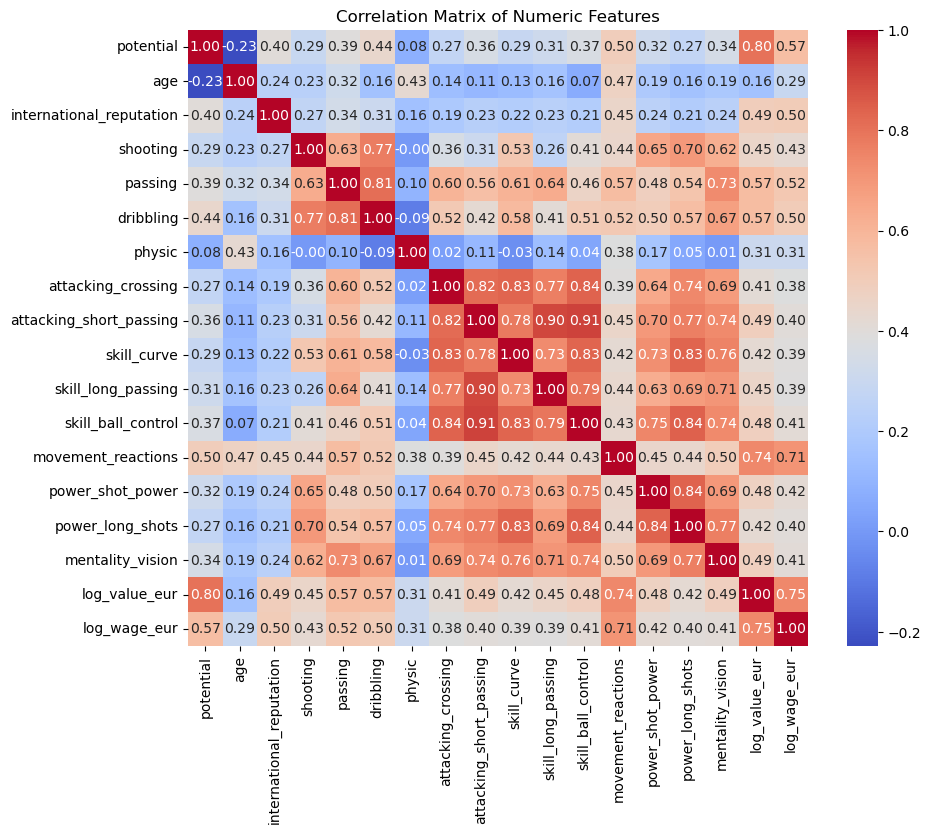

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = corr_matrix.astype(float)
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [17]:
# Given the correlation matrix, we will drop the following columns
strong_corr_groups = [['shooting', 'dribbling', 'passing'], ['skill_long_passing', 'attacking_short_passing', 'skill_ball_control', 'skill_curve', 'power_shot_power', 'power_long_shots', 'mentality_vision']]

# We will keep one of the columns in each group
strongest_corr_with_target = 0
strongest_corr_col = ''
keep_col = []
for group in strong_corr_groups:
    for col in group:
        if feature_correlation_with_target[col] > strongest_corr_with_target:
            strongest_corr_with_target = feature_correlation_with_target[col]
            strongest_corr_col = col
    keep_col.append(strongest_corr_col)
    strongest_corr_with_target = 0
print(f"Selected columns: {keep_col}")

dropped_cols = []
for group in strong_corr_groups:
    for col in group:
        if col not in keep_col:
            dropped_cols.append(col)
print(f"Dropped columns: {dropped_cols}")

df_scaled = df_scaled.drop(*dropped_cols)
print(df_scaled.columns)

Selected columns: ['passing', 'mentality_vision']
Dropped columns: ['shooting', 'dribbling', 'skill_long_passing', 'attacking_short_passing', 'skill_ball_control', 'skill_curve', 'power_shot_power', 'power_long_shots']
['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'league_level', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeepin

In [18]:
from pyspark.sql import functions as F
from functools import reduce

def find_outliers(df):
    # Assuming df.columns are all numeric. If not, filter non-numeric columns first.
    numeric_columns = df.columns

    print("Starting outlier detection...")
    outlier_flags = []

    for col in numeric_columns:
        print(f"Processing column: {col}")
        Q1, Q3 = df.approxQuantile(col, [0.25, 0.75], relativeError=0)
        IQR = Q3 - Q1

        less_Q1 = Q1 - 1.5 * IQR
        more_Q3 = Q3 + 1.5 * IQR

        outlier_flag = F.when((F.col(col) < less_Q1) | (F.col(col) > more_Q3), 1).otherwise(0)
        outlier_flags.append(outlier_flag.alias(f'is_outlier_{col}'))

    print("Aggregating outlier conditions...")
    df = df.select("*", *outlier_flags)

    print("Calculating total outliers...")
    total_outliers_expr = '+'.join([f'is_outlier_{col}' for col in numeric_columns])
    df = df.withColumn('total_outliers', F.expr(total_outliers_expr))

    # Optionally, drop the individual outlier columns if they are not needed
    df = df.drop(*[f'is_outlier_{col}' for col in numeric_columns])

    return df

In [23]:
# Finding outliers in the dataset
# We start with filtering out non-numeric columns in the dataset
numeric_columns = [column[0] for column in df_scaled.dtypes if column[1]in ('int', 'double')]
col_to_drop = ['overall',  'potential', 'value_eur', 'wage_eur', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation',  'preferred_foot_index', 'work_rate_index', 'body_type_index']
numeric_columns = [col for col in numeric_columns if col not in col_to_drop]
print(f"Numeric columns: {numeric_columns}")

# Since conducting outlier detection on the entire dataset is computationally expensive, we will choose some of the highly correlated features to conduct outlier detection
high_correlated_cols = [col for col in numeric_columns if feature_correlation_with_target[col] > 0.4]
print(f"Highly correlated columns: {high_correlated_cols}")

df_outliers = find_outliers(df_scaled.select(high_correlated_cols))
df_outliers.groupby("total_outliers").count().show()


Numeric columns: ['age', 'height_cm', 'weight_kg', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'log_value_eur', 'log_wage_eur']
Highly correlated columns: ['age', 'passing', 'physic', 'attacking_crossing', 'movement_reactions', 'mentality_vision', 'log_value_eur', 'log_wage_eur']
Starting outlier detection...
Processing column: age
Processing column: passing
Processing col

In [24]:
col_to_drop = ['value_eur', 'wage_eur', 'preferred_foot_index', 'work_rate_index', 'body_type_index', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec']
general_engineered_df = df_scaled.drop(*col_to_drop)

In [25]:
# Vector Assmebling steps
from pyspark.ml.feature import VectorAssembler

feature_cols = df_scaled.drop('value_eur', 'wage_eur', 'preferred_foot', 'overall', 'work_rate', 'body_type', 'preferred_foot_index', 'work_rate_index', 'body_type_index').columns
print(feature_cols)

['potential', 'age', 'height_cm', 'weight_kg', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec', 'log_value_eur', 'log_wage_eur']


In [26]:
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_assembled = vector_assembler.transform(df_scaled)

In [27]:
# Splitting the data into training and testing sets
train, test = df_assembled.randomSplit([0.7, 0.3], seed=504)
train = train.select("features", "overall")
test = test.select("features", "overall")

df_factioned = df_assembled.sample(False, 0.7, seed=504)
train_reduced, test_reduced = df_assembled.randomSplit([0.7, 0.3], seed=504)

train.show(10)
test.show(10)

+--------------------+-------+
|            features|overall|
+--------------------+-------+
|[51.0,23.0,186.0,...|     47|
|[61.0,18.0,178.0,...|     47|
|[52.0,23.0,165.0,...|     48|
|[56.0,17.0,188.0,...|     49|
|[60.0,19.0,188.0,...|     49|
|[61.0,19.0,182.0,...|     49|
|[61.0,20.0,186.0,...|     50|
|[73.0,17.0,179.0,...|     50|
|[55.0,21.0,184.0,...|     51|
|[59.0,17.0,178.0,...|     51|
+--------------------+-------+
only showing top 10 rows

+--------------------+-------+
|            features|overall|
+--------------------+-------+
|[67.0,18.0,162.0,...|     49|
|[64.0,20.0,172.0,...|     50|
|[51.0,32.0,185.0,...|     51|
|[51.0,28.0,188.0,...|     51|
|[61.0,18.0,194.0,...|     51|
|[63.0,19.0,182.0,...|     51|
|[66.0,17.0,175.0,...|     51|
|[68.0,17.0,181.0,...|     51|
|[59.0,20.0,191.0,...|     52|
|[59.0,21.0,169.0,...|     52|
+--------------------+-------+
only showing top 10 rows



In [28]:
# First model: Linear Regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='overall')

# Train the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="overall", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)
train_pred = lr_model.transform(train)
train_mse = evaluator.evaluate(train_pred)
print(f"Mean Squared Error (RMSE) on train data = {train_mse}")
print(f"Mean Squared Error (RMSE) on test data = {mse}")


23/11/16 22:45:29 WARN Instrumentation: [9c4c1877] regParam is zero, which might cause numerical instability and overfitting.


Mean Squared Error (RMSE) on train data = 1.1872904294453857
Mean Squared Error (RMSE) on test data = 1.3642409844009937


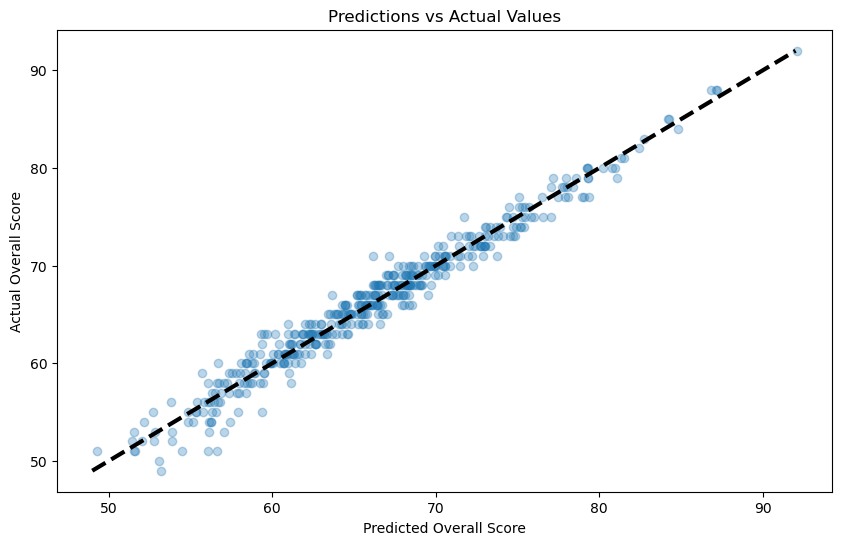

In [29]:
import matplotlib.pyplot as plt
# Collecting predictions and actual values
predicted_vs_actual = predictions.select("prediction", "overall").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(predicted_vs_actual['prediction'], predicted_vs_actual['overall'], alpha=0.3)
plt.title('Predictions vs Actual Values')
plt.xlabel('Predicted Overall Score')
plt.ylabel('Actual Overall Score')
plt.plot([predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 
         [predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 'k--', lw=3)
plt.show()

In [30]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LinearRegression(featuresCol='features', labelCol='overall')

lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.001, 0.01, 1.0])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .build())

evaluator = RegressionEvaluator(labelCol="overall", predictionCol="prediction", metricName="rmse")

lr_crossval = CrossValidator(estimator=lr,
                                estimatorParamMaps=lr_paramGrid,
                                evaluator=evaluator,
                                numFolds=5)

lr_cvModel = lr_crossval.fit(train)

lr_bestModel = lr_cvModel.bestModel

cv_train_pred = lr_bestModel.transform(train)
cv_train_rmse = evaluator.evaluate(cv_train_pred)

cv_test_pred = lr_bestModel.transform(test)
cv_test_rmse = evaluator.evaluate(cv_test_pred)

print(f"Best Model Train RMSE: {cv_train_rmse}")
print(f"Best Model Test RMSE: {cv_test_rmse}")

Best Model Train RMSE: 1.2071090634608017
Best Model Test RMSE: 1.3444480662570897


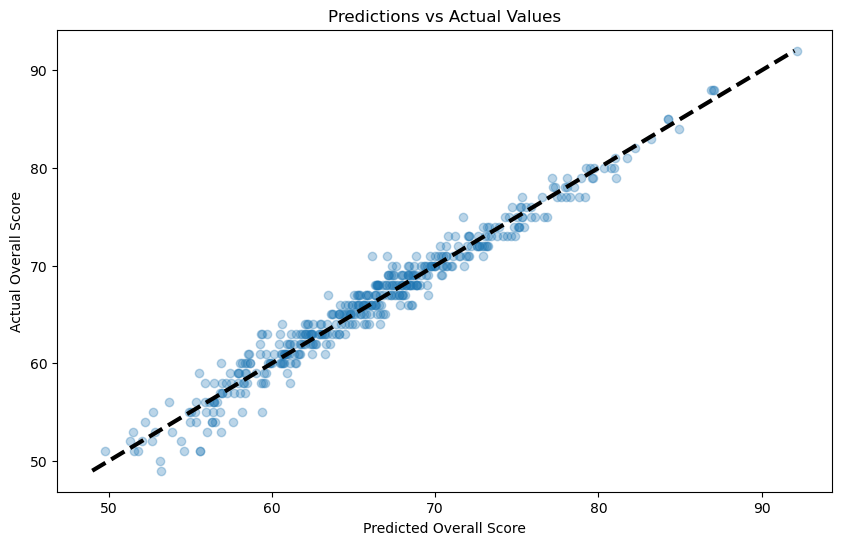

In [31]:
import matplotlib.pyplot as plt
# Collecting predictions and actual values
predicted_vs_actual = cv_test_pred.select("prediction", "overall").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(predicted_vs_actual['prediction'], predicted_vs_actual['overall'], alpha=0.3)
plt.title('Predictions vs Actual Values')
plt.xlabel('Predicted Overall Score')
plt.ylabel('Actual Overall Score')
plt.plot([predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 
         [predicted_vs_actual['overall'].min(), predicted_vs_actual['overall'].max()], 'k--', lw=3)
plt.show()

In [32]:
lr_bestModel.extractParamMap()

{Param(parent='LinearRegression_d06d060aa437', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_d06d060aa437', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_d06d060aa437', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_d06d060aa437', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_d06d060aa437', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_d06d060aa437', name='labelCol', doc='label column name.'): 'overall',
 Param(parent='LinearRegression_d06d060aa437', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 'squaredErr

In [33]:
import pandas as pd

coefficients = lr_bestModel.coefficients

feature_importance = pd.DataFrame(list(zip(feature_cols, coefficients)), columns=["Feature", "Coefficient"])

# Sort by absolute value of coefficient
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print(feature_importance[['Feature', 'Abs_Coefficient']])

remove_cols = feature_importance[feature_importance['Abs_Coefficient'] < 0.005]['Feature'].tolist()
print(f"Columns to remove: {remove_cols}")

                        Feature  Abs_Coefficient
1                           age         0.447667
0                     potential         0.224731
43                 log_wage_eur         0.132840
7      international_reputation         0.124234
41                body_type_vec         0.102795
39           preferred_foot_vec         0.095452
21           movement_reactions         0.059597
35         goalkeeping_handling         0.034764
9                       passing         0.023941
14   attacking_heading_accuracy         0.019157
19        movement_sprint_speed         0.017651
38         goalkeeping_reflexes         0.015708
3                     weight_kg         0.015287
16              skill_dribbling         0.010818
37      goalkeeping_positioning         0.009938
25               power_strength         0.009033
27      mentality_interceptions         0.007853
18        movement_acceleration         0.006923
24                power_stamina         0.005895
31  defending_markin

In [34]:
feature_cols = [col for col in feature_cols if col not in remove_cols]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_assembled = vector_assembler.transform(df_scaled)
train, test = df_assembled.randomSplit([0.7, 0.3], seed=504)

df_factioned = df_assembled.sample(False, 0.8, seed=504)
train_reduced, test_reduced = df_assembled.randomSplit([0.7, 0.3], seed=504)

In [35]:
# Now we will do random forest regression
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='overall')

rf_model = rf.fit(train_reduced)

train_pred = rf_model.transform(train_reduced)
test_pred = rf_model.transform(test_reduced)

evaluator = RegressionEvaluator(labelCol="overall", predictionCol="prediction", metricName="rmse")

train_rmse = evaluator.evaluate(train_pred)
test_rmse = evaluator.evaluate(test_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 2.072538534876644
Test RMSE: 2.3401065169858013


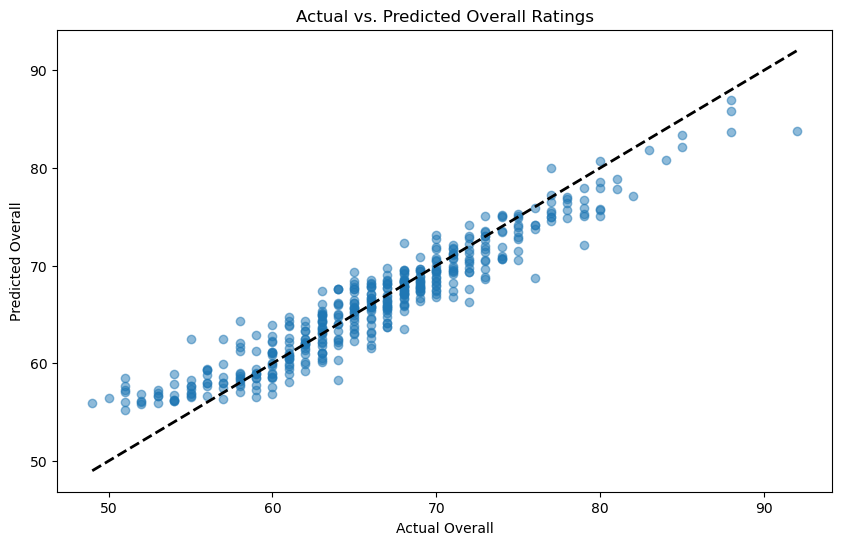

In [36]:
predictions_pd = test_pred.select('overall', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['overall'], predictions_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Overall')
plt.ylabel('Predicted Overall')
plt.title('Actual vs. Predicted Overall Ratings')
plt.plot([predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         [predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         'k--', lw=2)  # Diagonal line for reference
plt.show()


In [37]:
rf = RandomForestRegressor(featuresCol='features', labelCol='overall')

# Define a parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [25, 35])
             .addGrid(rf.maxDepth, [8, 10])
             .build())

# Define the evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="overall", metricName="rmse")

# Setup CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
print('Stage 0: Completed!')
# Fit the model
cvModel = cv.fit(train_reduced)
print('Stage 1: Completed!')
bestmodel = cvModel.bestModel
# Make predictions and evaluate
test_pred = bestmodel.transform(test_reduced)
train_pred = bestmodel.transform(train_reduced)
train_rmse = evaluator.evaluate(train_pred)
test_rmse = evaluator.evaluate(test_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Stage 0: Completed!


23/11/16 22:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1117.1 KiB
23/11/16 22:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1376.0 KiB
23/11/16 22:48:18 WARN DAGScheduler: Broadcasting large task binary with size 1097.2 KiB
23/11/16 22:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1097.2 KiB
23/11/16 22:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1460.9 KiB
23/11/16 22:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1823.5 KiB
23/11/16 22:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB
23/11/16 22:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1406.7 KiB
23/11/16 22:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
23/11/16 22:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
23/11/16 22:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1483.3 KiB
23/11/16 22:48:29 WAR

Stage 1: Completed!
Train RMSE: 0.9158897556058841
Test RMSE: 1.838212035880988


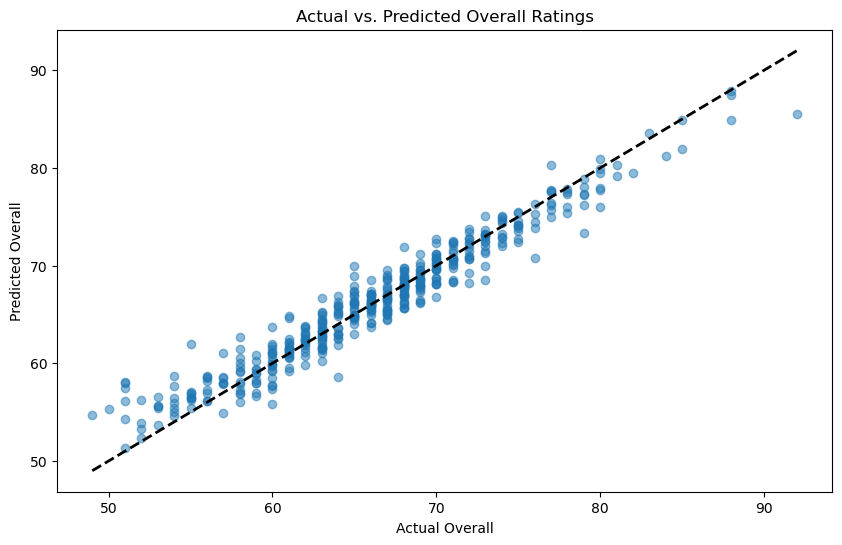

In [38]:
predictions_pd = test_pred.select('overall', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['overall'], predictions_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Overall')
plt.ylabel('Predicted Overall')
plt.title('Actual vs. Predicted Overall Ratings')
plt.plot([predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         [predictions_pd['overall'].min(), predictions_pd['overall'].max()], 
         'k--', lw=2)  # Diagonal line for reference
plt.show()

In [39]:
# Show best model summary
bestmodel.extractParamMap()


{Param(parent='RandomForestRegressor_dae58f1ecf08', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestRegressor_dae58f1ecf08', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestRegressor_dae58f1ecf08', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestRegressor_dae58f1ecf08', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supporte